# <h1>How to analyze T-maze EEG-fMRI data</h1>

<h2>EEG segmentation and averaging</h2>

<p>A quick example of how to load the preprocessed data
and generate a 3d animated topo map of the evoked data 
as demonstrated here: https://gist.github.com/kingjr/061f28265555ac97329d2c80132d1b57</p>

In [1]:
import mne

import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import Delaunay
import ipyvolume as p3

First of all, we have to perform a segmentation I already extracted the necessary event timings and divided feedback
by maze vs. no maze, left vs. right and of course reward vs. no reward for the fMRI analysis. 
Here, the same timings shall be used in a different format.

In [106]:
%%capture
os.chdir('/Volumes/INTENSO/EEG_fMRI_tmaze')

event_file1 = './events/events1-eve.fif'
events1 = mne.read_events(event_file1)
event_file2 = './events/events2-eve.fif'
events2 = mne.read_events(event_file2)
event_file3 = './events/events3-eve.fif'
events3 = mne.read_events(event_file3)

# Define the event ids
event_id = {'reward_left_maze': 1, 'reward_right_maze': 2,
            'reward_left_nomaze': 3, 'reward_right_nomaze': 4,
            'noreward_left_maze': 5, 'noreward_right_maze': 6,
            'noreward_left_nomaze': 7, 'noreward_right_nomaze': 8,
            'slows': 9}

The event data is a x-by-3 array with the rows containing the events in chronological order and the columns their respective event info 
(timing in sample points, value of the event channel before/after, integer assigned to an event id)

In [4]:
events1[:20]

array([[ 49166,      0,      1],
       [ 52166,      0,      1],
       [ 55182,      0,      6],
       [ 58182,      0,      5],
       [ 61198,      0,      1],
       [ 64198,      0,      2],
       [ 67214,      0,      2],
       [ 73230,      0,      6],
       [ 76246,      0,      5],
       [ 82245,      0,      9],
       [ 85245,      0,      2],
       [ 88245,      0,      6],
       [ 91261,      0,      1],
       [ 94277,      0,      2],
       [103276,      0,      2],
       [112292,      0,      1],
       [115308,      0,      2],
       [121224,      0,      9],
       [124240,      0,      5],
       [130256,      0,      6]])

In [7]:
%%capture
# Load the raw data for the first and second sub into memory
file1 = './raw/tmaze01_ica-raw.fif'
file2 = './raw/tmaze02_ica-raw.fif' 
file2 = './raw/tmaze03_ica-raw.fif' 

raw1 = mne.io.read_raw_fif(file1, preload=True)
raw2 = mne.io.read_raw_fif(file2, preload=True)
raw3 = mne.io.read_raw_fif(file3, preload=True)

raw1.filter(1,20)
raw2.filter(1,20)
raw3.filter(1,20)

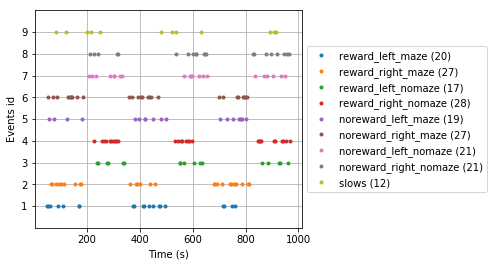

In [10]:
# Just to check on the distribution, plot the event IDs across time
mne.viz.plot_events(events1, raw1.info['sfreq'], raw1.first_samp, 
                    color=None, event_id=event_id);

In [8]:
%%capture
# Perform a segmentation based on the events and event_ids on both

tmin, tmax = -0.2, 0.8
baseline = -0.2, -0.1

epochs1 = mne.Epochs(raw1, events=events1, event_id=event_id, 
                     picks=None, tmin=tmin, tmax=tmax,
                     preload=True, baseline=baseline)

epochs2 = mne.Epochs(raw2, events=events2, event_id=event_id, 
                     picks=None, tmin=tmin, tmax=tmax,
                     preload=True, baseline=baseline)

epochs3 = mne.Epochs(raw3, events=events2, event_id=event_id, 
                     picks=None, tmin=tmin, tmax=tmax,
                     preload=True, baseline=baseline)

In [109]:
rew_conditions = ['reward_left_maze','reward_right_maze','reward_right_nomaze','reward_left_nomaze']
norew_conditions = ['noreward_left_maze','noreward_right_maze','noreward_right_nomaze','noreward_left_nomaze']

reward = mne.grand_average([epochs1['reward_left_maze','reward_right_maze'].average(),
                            epochs2['reward_left_maze','reward_right_maze'].average(),
                            epochs3['reward_left_maze','reward_right_maze'].average()])

noreward = mne.grand_average([epochs1['noreward_left_maze','noreward_right_maze'].average(),
                              epochs2['noreward_left_maze','noreward_right_maze'].average(),
                              epochs3['noreward_left_maze','noreward_right_maze'].average()])

left = mne.grand_average([epochs1['reward_left_nomaze','noreward_left_nomaze'].average(),
                          epochs2['reward_left_maze','noreward_left_maze'].average(),
                          epochs3['reward_left_maze','noreward_left_maze'].average()])

right = mne.grand_average([epochs1['reward_right_maze','noreward_right_maze'].average(),
                           epochs2['reward_right_maze','noreward_right_maze'].average(),
                           epochs3['reward_right_maze','noreward_right_maze'].average()])


reward_nomaze = mne.grand_average([epochs1['reward_left_nomaze','reward_right_nomaze'].average(),
                                   epochs2['reward_left_nomaze','reward_right_nomaze'].average(),
                                   epochs3['reward_left_nomaze','reward_right_nomaze'].average()])


noreward_nomaze = mne.grand_average([epochs1['noreward_left_nomaze','noreward_right_nomaze'].average(),
                                     epochs2['noreward_left_nomaze','noreward_right_nomaze'].average(),
                                     epochs3['noreward_left_nomaze','noreward_right_nomaze'].average()])

left_nomaze = mne.grand_average([epochs1['reward_left_nomaze','noreward_left_nomaze'].average(),
                                 epochs2['reward_left_nomaze','noreward_left_nomaze'].average(),
                                 epochs3['reward_left_nomaze','noreward_left_nomaze'].average()])

right_nomaze = mne.grand_average([epochs1['reward_right_nomaze','noreward_right_nomaze'].average(),
                                  epochs2['reward_right_nomaze','noreward_right_nomaze'].average(),
                                  epochs3['reward_right_nomaze','noreward_right_nomaze'].average()])

Identifying common channels ...
all channels are corresponding, nothing to do.
Identifying common channels ...
all channels are corresponding, nothing to do.
Identifying common channels ...
all channels are corresponding, nothing to do.
Identifying common channels ...
all channels are corresponding, nothing to do.
Identifying common channels ...
all channels are corresponding, nothing to do.
Identifying common channels ...
all channels are corresponding, nothing to do.
Identifying common channels ...
all channels are corresponding, nothing to do.
Identifying common channels ...
all channels are corresponding, nothing to do.
Identifying common channels ...
all channels are corresponding, nothing to do.
Identifying common channels ...
all channels are corresponding, nothing to do.


In [107]:
difference_feedback = mne.combine_evoked((reward,noreward),[-1,1])
difference_feedback_nomaze = mne.combine_evoked((reward_nomaze,noreward_nomaze),[-1,1])

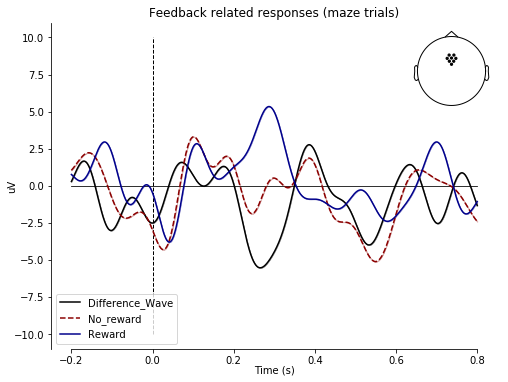

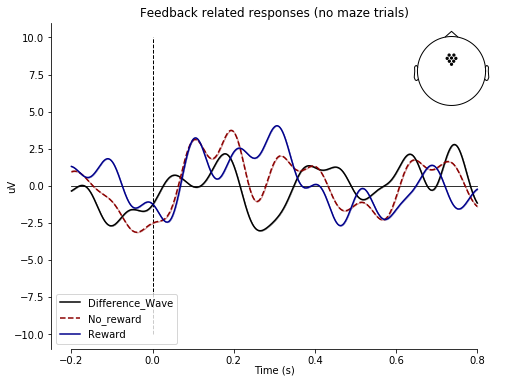

In [93]:
FCz = [14, 21, 13, 15, 6, 7, 5, 22]

colors = dict(Reward = 'darkblue', No_reward = 'darkred', 
              Difference_Wave = 'black')

maze_dict = {'Reward': reward, 'No_reward': noreward, 
               'Difference_Wave': difference_feedback}
nomaze_dict = {'Reward': reward_nomaze, 'No_reward': noreward_nomaze, 
               'Difference_Wave': difference_feedback_nomaze}

linestyles = dict(Reward = '-', No_reward = '--', 
                  Difference_Wave = '-')

ylim = dict(eeg=[-10,10])

mne.viz.plot_compare_evokeds(maze_dict, picks=FCz, 
                             truncate_yaxis=False, truncate_xaxis=False,
                             colors=colors, linestyles=linestyles,
                             invert_y=False, ylim = ylim,
                             title='Feedback related responses (maze trials)',
                             show_sensors=True, ci=.9);

mne.viz.plot_compare_evokeds(nomaze_dict, picks=FCz, 
                             truncate_yaxis=False, truncate_xaxis=False,
                             colors=colors, linestyles=linestyles,
                             invert_y=False, ylim = ylim,
                             title='Feedback related responses (no maze trials)',
                             show_sensors=True, ci=.9);

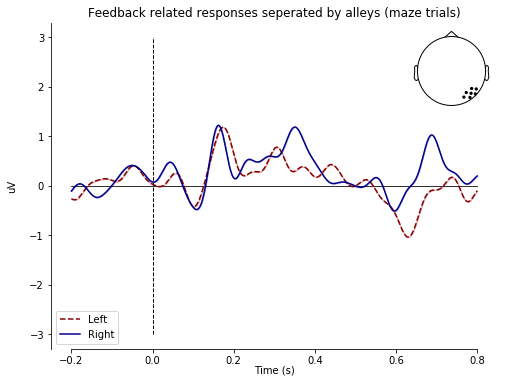

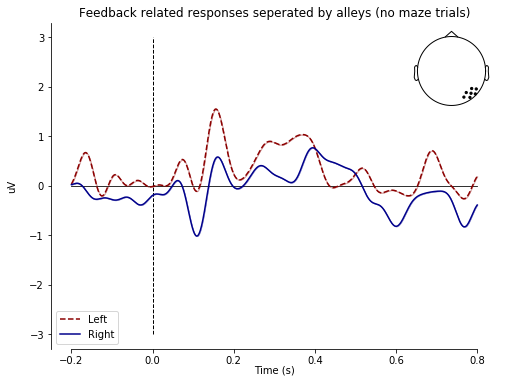

In [123]:
PO8 = [169, 176, 177, 168, 167, 159, 158]

colors = dict(Right = 'darkblue', Left = 'darkred') 

maze_dict = {'Right': right, 'Left': left} 
nomaze_dict = {'Right': right_nomaze, 'Left': left_nomaze} 

linestyles = dict(Right = '-', Left = '--') 

ylim = dict(eeg=[-3,3])

mne.viz.plot_compare_evokeds(maze_dict, picks=PO8, 
                             truncate_yaxis=False, truncate_xaxis=False,
                             colors=colors, linestyles=linestyles,
                             invert_y=False, ylim = ylim,
                             title='Feedback related responses seperated by alleys (maze trials)',
                             show_sensors=True, ci=.9);

mne.viz.plot_compare_evokeds(nomaze_dict, picks=PO8, 
                             truncate_yaxis=False, truncate_xaxis=False,
                             colors=colors, linestyles=linestyles,
                             invert_y=False, ylim = ylim,
                             title='Feedback related responses seperated by alleys (no maze trials)',
                             show_sensors=True, ci=.9);

In [150]:
cmap = plt.get_cmap('RdBu_r')
data = np.array(reward_nomaze.data)

n_chans, n_times = data.shape
vmax = data.max()
data[data<=-vmax] = -vmax
data[data>=vmax] = vmax
data -= -vmax
data /= 2*vmax
colors = np.reshape(cmap(data.ravel())[:, :3], [n_chans, n_times, 3])
colors = colors.transpose(1, 0, 2)

pos3D = np.array([ch['loc'][:3] for ch in reward.info['chs']])
tri3D = Delaunay(pos3D).convex_hull

In [151]:
fig = p3.figure()
s = p3.plot_trisurf(pos3D[:, 0], pos3D[:, 1], [pos3D[:, 2] for _ in range(n_times)],
                    triangles=tri3D, color=colors)
p3.xyzlim(pos3D.min(), pos3D.max())
p3.animation_control(s, interval=10)
p3.show()

In [152]:
pos = mne.find_layout(reward.info).pos[:, :3]
pos -= pos.mean(0, keepdims=True)
pos[:, 2] = (1-(pos[:, 0] ** 2 + pos[:, 1] ** 2))/1e3
tri2D = Delaunay(pos).convex_hull

In [153]:
fig = p3.figure()
s = p3.plot_trisurf(pos[:, 0], pos[:, 1], [pos[:, 2] for _ in range(n_times)],
                    triangles=tri2D, color=colors)
p3.xyzlim(pos.min(), pos.max())
p3.animation_control(s, interval=10, add=True)
p3.show()